In [1]:
import  numpy  as  np
import libpysal as ps
from stwr.gwr import GWR, MGWR,STWR
from stwr.sel_bw import *
from stwr.utils import shift_colormap, truncate_colormap
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot
import pandas as pd
import math
from matplotlib.gridspec import GridSpec
import time
import csv 
import copy 

In [2]:
import rasterio
import rasterio.plot
import rasterio.features
import rasterio.warp
import pyproj

In [3]:
#Read Data.
#list of coordinates
cal_coords_list =[]
#list of y
cal_y_list =[]
#list of X
cal_X_list =[]
#time intervel list
delt_stwr_intervel =[0.0]
csvFile = open("../Data_STWR/RealWorldData/precip_isotope_D3.csv", "r")
df = pd.read_csv(csvFile,header = 0,names=['Longitude','Latitude','Elevation','ppt','tmean','d2h','timestamp'],
                 dtype = {"Longitude" : "float64","Latitude":"float64",
                          "Elevation":"float64","ppt":"float64","tmean":"float64","d2h":"float64",
                          "timestamp":"float64"},
                 skip_blank_lines = True,
                 keep_default_na = False)
df.info()
#Sort the records by observation time.
df = df.sort_values(by=['timestamp'])  
all_data = df.values
tick_time = all_data[0,-1]
cal_coord_tick = []
cal_X_tick =[]
cal_y_tick =[]

#If the time interval is less than "time_tol", the observation time is considered to be the same.
time_tol = 1.0e-7
# all records
lensdata = len(all_data) # number of rows, or number of observations.
for row in range(lensdata): # traverse all observation data
    cur_time = all_data[row,-1] # get current timestamp
    # if the timestamp changes, 
    if(abs(cur_time-tick_time)>time_tol):
        cal_coords_list.append(np.asarray(cal_coord_tick))
        cal_X_list.append(np.asarray(cal_X_tick))
        cal_y_list.append(np.asarray(cal_y_tick))
        delt_t = cur_time - tick_time
        delt_stwr_intervel.append(delt_t) 
        tick_time =cur_time
        cal_coord_tick = []
        cal_X_tick =[]
        cal_y_tick =[]
    coords_tick = np.array([all_data[row,0],all_data[row,1]]) ## find the coords in your data
    cal_coord_tick.append(coords_tick)

    x_tick = np.array([all_data[row,2],all_data[row,3],all_data[row,4]]) ## this is to get all your X, here we have X1, X2, X3.
    cal_X_tick.append(x_tick)
    y_tick = np.array([all_data[row,5]]) ## find the y in your data
    cal_y_tick.append(y_tick)

#GWR only processes the last observation data point.
cal_cord_gwr = np.asarray(cal_coord_tick)
cal_X_gwr  = np.asarray(cal_X_tick)
cal_y_gwr = np.asarray(cal_y_tick)  
cal_coords_list.append(np.asarray(cal_coord_tick))
cal_X_list.append(np.asarray(cal_X_tick))
cal_y_list.append(np.asarray(cal_y_tick))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  272 non-null    float64
 1   Latitude   272 non-null    float64
 2   Elevation  272 non-null    float64
 3   ppt        272 non-null    float64
 4   tmean      272 non-null    float64
 5   d2h        272 non-null    float64
 6   timestamp  272 non-null    float64
dtypes: float64(7)
memory usage: 15.0 KB


In [4]:
#spherical is the parameter to set whether it is spherical coordinates or Euclidean coordinates
stwr_selector_ = Sel_Spt_BW(cal_coords_list, cal_y_list, cal_X_list,#gwr_bw0,
                            delt_stwr_intervel,spherical = True)
#Search for optimal bandwidth.
optalpha,optsita,opt_btticks,opt_gwr_bw0 = stwr_selector_.search() 
#Build the STWR model.  
stwr_model = STWR(cal_coords_list,cal_y_list,cal_X_list,delt_stwr_intervel,optsita,opt_gwr_bw0,tick_nums=opt_btticks+1,alpha =optalpha,spherical = True,recorded=1)

In [5]:
#Fit the STWR model
stwr_results = stwr_model.fit()
stwr_results.summary()

stwr_scale = stwr_results.scale 
stwr_residuals = stwr_results.resid_response

Model type                                                         Gaussian
Number of observations:                                                 182
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          52669.399
Log-likelihood:                                                    -343.801
AIC:                                                                695.602
AICc:                                                               698.498
BIC:                                                              52373.357
R2:                                                                   0.502
Adj. R2:                                                              0.481

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [6]:
#GWR only processes the data points observed at the the lastest time stage .
gwr_selector = Sel_BW(cal_cord_gwr, cal_y_gwr, cal_X_gwr,spherical = True)
#Search the bandwidth
gwr_bw= gwr_selector.search(bw_min=2)
#build the GWR model 
gwr_model = GWR(cal_cord_gwr, cal_y_gwr, cal_X_gwr, gwr_bw,spherical = True)
gwr_results = gwr_model.fit()
gwr_results.summary()

gw_rscale = gwr_results.scale 
gwr_residuals = gwr_results.resid_response

Model type                                                         Gaussian
Number of observations:                                                  73
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          52669.399
Log-likelihood:                                                    -343.801
AIC:                                                                695.602
AICc:                                                               698.498
BIC:                                                              52373.357
R2:                                                                   0.502
Adj. R2:                                                              0.481

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [7]:
#Prediction
#list of coordintates need to be predict.
Pred_Coords_list =[]
#list of  X values of the coordinates.
X_pre_list = []
theight1 = rasterio.open('../Data_STWR/RealWorldData/extgmted1.tif') ## elevation
bheight1 = theight1.read(1) 
ppt1 = rasterio.open('../Data_STWR/RealWorldData/extppt1.tif')  ## precipitation
bppt1 = ppt1.read(1)
mean1 = rasterio.open('../Data_STWR/RealWorldData/extmean1.tif') ## Tmeans
bmean1 = mean1.read(1)

# These three TIF should have the same profile
ppt1.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.402823e+38, 'width': 552, 'height': 327, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.041666666667, 0.0, -90.00013888888888,
       0.0, -0.041666666666999995, 47.486804962267), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}

In [8]:
# These three TIF should have the same profile
ppt1.profile == mean1.profile

True

In [9]:
#record the profile of the "*.tif" file, including the information about the transform and "nodata".
pf = ppt1.profile
transform =ppt1.profile['transform']
nodata = pf['nodata']

In [10]:
# Z is the predicted y surface of STWR model
Z =  bppt1.copy()
#Z = Z.astype(np.float64)

#Z2 is the predicted y surface of GWR model
Z2 = bppt1.copy()
#Z2 = Z2.astype(np.float64)

In [11]:


mask = ppt1.dataset_mask() 
for row in range(mask.shape[0]):
    for col in range (mask.shape[1]):
        if(mask[row,col]>0):
            X_tick = np.array([bheight1[row,col],bppt1[row,col],bmean1[row,col]])
            X_pre_list.append(X_tick) # X used for prediction
            Pred_Coords_list.append(ppt1.xy(row,col)) # coords for prediction

            
X_pre_arr = np.asarray(X_pre_list)
alllen_stwr = len(Pred_Coords_list)
allklen_stwr = X_pre_arr.shape[1]+1
rec_parmas_stwr = np.ones((alllen_stwr,allklen_stwr))
calen_stwr =  len(cal_y_list[-1])
prelen_stwr = X_pre_arr.shape[0]
#list of y predicted by the STWR model
Pre_y_list = np.ones_like(X_pre_arr[:,1])
#list of y predicted by the GWR model
Pre_gwr_y_list = Pre_y_list.copy()

stwr_pre_parmas = np.ones((prelen_stwr,allklen_stwr))
#If the number of points to be predicted is more than the number we used for building the model(STWR or GWR),
# their prediciton need to be split into servel parts.
if (calen_stwr>=prelen_stwr):
       predPointList = Pred_Coords_list
       PreX_list = X_pre_arr
       #Predicted result of STWR 
       pred_stwr_dir_result = stwr_model.predict(predPointList,PreX_list,stwr_scale,stwr_residuals)
       pre_y_stwr = pred_stwr_dir_result.predictions 
       #Predicted result of GWR 
       pred_gwr_dir_result = gwr_model.predict(predPointList,PreX_list,gw_rscale,gwr_residuals)
       pre_y_gwr = pred_gwr_dir_result.predictions
       #gwr
else:
        spl_parts_stwr = math.ceil(prelen_stwr*1.0/calen_stwr) 
        spl_X_stwr = np.array_split(X_pre_arr, spl_parts_stwr, axis = 0)
        spl_coords_stwr = np.array_split(Pred_Coords_list, spl_parts_stwr, axis = 0)
        pred_stwr_result = np.array_split(Pre_y_list, spl_parts_stwr, axis = 0)
        #uncomment if you want to predict the coefficient surfaces by STWR model.
#        pred_stwrparmas_result = np.array_split(stwr_pre_parmas, spl_parts_stwr, axis = 0)
        #uncomment if you want to predict the coefficient surfaces by STWR model.
        #Split the y  to be predicted into servel parts for GWR prediction
        pred_gwr_result = np.array_split(Pre_gwr_y_list, spl_parts_stwr, axis = 0)
        #Split the y  to be predicted into servel parts for GWR prediction
        
        for j in range(spl_parts_stwr):
                predPointList_tick = [spl_coords_stwr[j]]
                PreX_list_tick = [spl_X_stwr[j]]
                pred_stwr_spl_result =  stwr_model.predict(predPointList_tick,PreX_list_tick,stwr_scale,stwr_residuals)
                pred_stwr_result[j] =pred_stwr_spl_result.predictions 
                #uncomment if you want to predict the coefficient surfaces by STWR model.
#               pred_stwrparmas_result[j] =np.reshape(pred_stwr_spl_result.params.flatten(),(-1,allklen_stwr))
                #uncomment if you want to predict the coefficient surfaces by STWR model.
    
                #GWR
                pred_gwr_spl_result =  gwr_model.predict(spl_coords_stwr[j],spl_X_stwr[j],gw_rscale,gwr_residuals)
                pred_gwr_result[j] =pred_gwr_spl_result.predictions
                #GWR
        pre_y_stwr = pred_stwr_result[0]
#        pre_parmas_stwr = pred_stwrparmas_result[0]
        combnum = spl_parts_stwr-1
        #gwr
        pre_y_gwr=pred_gwr_result[0]
        #gwr
        for s in range(combnum):
            pre_y_stwr = np.vstack((pre_y_stwr,pred_stwr_result[s+1]))
#            pre_parmas_stwr = np.vstack((pre_parmas_stwr,pred_stwrparmas_result[s+1]))
            #gwr
            pre_y_gwr = np.vstack((pre_y_gwr,pred_gwr_result[s+1]))
            #gwr

In [12]:
idx = 0  
mask_ppt = ppt1.dataset_mask()

for row in range(mask_ppt.shape[0]):
    for col in range (mask_ppt.shape[1]):
        if(mask[row,col]>0):
                Z[row,col] = pre_y_stwr[idx]
                #Predicted y surface by GWR 
                Z2[row,col] = pre_y_gwr[idx]
                #Predicted y surface by GWR 
                idx = idx+1

#Output the predicted y surface by STWR.
with rasterio.open('../Data_STWR/RealWorldData/output/Rst3_stwr_nd_newt.tif', 'w', driver='GTiff', 
                   height=Z.shape[0],
                   width=Z.shape[1], count=1, dtype=Z.dtype,
                   crs='+proj=latlong', transform=transform,nodata = nodata) as dststwr:
    dststwr.write(Z, 1)
    
#Output the predicted y surface by GWR.
with rasterio.open('../Data_STWR/RealWorldData/output/Rst3_gwr_nd_newt.tif', 'w', driver='GTiff', 
                   height=Z2.shape[0],
                   width=Z2.shape[1], count=1, dtype=Z2.dtype,
                   crs='+proj=latlong', transform=transform,nodata = nodata) as dstgwr:
    dstgwr.write(Z2, 1)  

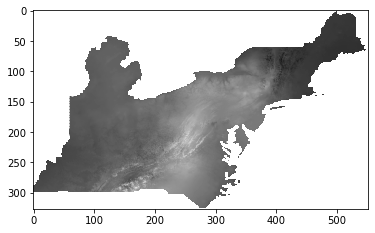

In [13]:
# pyplot.title("Predicted δ2H Surface of STWR")
pyplot.imshow(Z,cmap='binary',vmin=-238.478, vmax=18.4553)
pyplot.show()

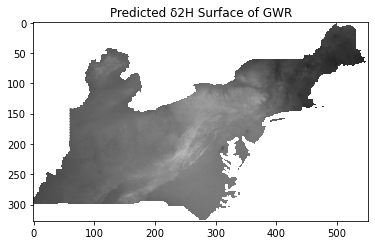

In [14]:
pyplot.title("Predicted δ2H Surface of GWR")
pyplot.imshow(Z2, cmap='binary',vmin=-238.478, vmax=18.4553)
pyplot.show()